# **Predictive Model for Motor Vehicle Accidents: Injury and Fatality Prevention and Intersection Safety  (January 2015 - December 2024)**

#### *By Alejandro J. Ordonez*

**Version 1.0.1**

## **Project Overview**:

This project outlines the motor vehicle (cars, trucks, buses, motorcycle) accident data in NYC, based on intersection characteristics, finding patterns within drivers, accident concentration by zip code, and commonalities among high risk areas and vehicles. 

##### **Our Goal**: 

This project aims to create a model to predict potential injury or fatalities based on variables given by NYPD public data. It also aims to create an interactive heat map for intersection collisions and provide a comprehensive look at where collisions are occuring in NYC.

Further exploration of this model could aid insurance companies in adjusting premiums for high risk profiles and locations, provide government agencies with actionable data to improve traffic safety, and give new yorkers a compreshensive look at where accidents are occuring. 

We plan on doing so by analyzing historical accident data from the last 10 years, traffic patterns, and intersection structures. The predictive model will identify high risk areas and attempt to predict future accidents within a certain margin of error. 

##### **Methodology**: 

We plan on using NYC public data in order to create this model.

We will be using SQL, and more specifically Google's RDBMS BigQuery to retrieve and clean data. 

We will be using R to help with statistical analysis on the cleaned dataset, as well as to create the logistical regression model for injury/fatality analysis. 

And finally we will be using Tableau to create a heat map of high risk areas and intersections with high counts of collisions. 

# **Data Collection**

To get our dataset we looked on the NYC public data in order to find the motor vehicle accident data. 

We used this table for the personal profiles: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu/about_data

We used this table for the collision in the intersection: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

We used this table for the specific vehicles in the crashes: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4/about_data

All of the data that we have collected will be stored into a personal Google Cloud and we will use Google's BigQuery in order to query the data. 

**For this project we will refer to the dataset as `insurance` and the tables as `insurance.persons`, `insurance.crashes`, and `insurance.vehicles` respectively.**

# **Data Cleaning**

As of now, SQL queries in this notebook do not run, however the final product is in the `motor-vehicle-accident-model` repo under the csv: `clean_motor_vehicle_table`. The following steps document the data cleaning that created the CSV we will be using. 

Using BigQuery, we will first clean the first table, `insurance.persons`. We will filter out null values for relevant fields and select data in between 2015-2024. 

In [ ]:
"
SELECT *
FROM 
  `insurance.persons`
WHERE
  `CRASH_DATE` BETWEEN '2015-01-01' AND '2024-12-01'
  AND PERSON_TYPE IS NOT NULL
  AND PERSON_AGE IS NOT NULL 
  AND PERSON_AGE >0 
  AND PERSON_AGE <150
  AND PERSON_SEX IS NOT NULL
  AND COLLISION_ID IS NOT NULL
  AND PERSON_TYPE = 'Occupant'
  AND EMOTIONAL_STATUS IS NOT NULL
  AND POSITION_IN_VEHICLE LIKE '%Driver%'
  AND PERSON_INJURY IS NOT NULL
"

Now we will move onto the next table `insurance.crashes` where we will do largely the same thing as we did for the previous table. 

In [ ]:
"
SELECT *
FROM `insurance.crashes`
WHERE
   `CRASH DATE` BETWEEN '2015-01-01' AND '2024-12-01'
    AND BOROUGH IS NOT NULL
    AND `ZIP CODE` IS NOT NULL
    AND `ZIP CODE` > 10000
    AND COLLISION_ID IS NOT NULL
    AND `NUMBER OF PERSONS KILLED` IS NOT NULL
    AND `NUMBER OF PERSONS INJURED` IS NOT NULL
"

For the last table (`insurance.vehicles`) we need to condense down the types of vehicles from over 1000 into 11 types:

(Sedan, SUV, Taxi, Pickup Truck, Van, Emergency Vehicle, Livery, Bus, Motorcycle, Bicycle, Truck, and Other)

Like the other queries, we will also filter out null values for relevant fields and select data in between 2015-2024

In [ ]:
"
WITH cleaned_vehicles AS (
    SELECT 
        COLLISION_ID,
        DRIVER_LICENSE_STATUS,
        UPPER(TRIM(VEHICLE_TYPE)) AS VEHICLE_TYPE,
        DRIVER_SEX,
        
        --This case query will sort the type of vehicles (ex: motorcycles, trucks, sedans, SUVs) together
        CASE 
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SEDAN%' THEN 'Sedan'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SPORT UTILITY%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SUV%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%STATION WAGON%' THEN 'SUV'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TAXI%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%CAB%' THEN 'Taxi'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%PICK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TRUCK%' THEN 'Pickup Truck'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%VAN%' THEN 'Van'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%AMBULANCE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%FIRE TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%FDNY%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%POLICE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%EMERGENCY%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%EMS%' THEN 'Emergency Vehicle'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%LIVERY%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%LIMO%' THEN 'Livery'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%BUS%' THEN 'Bus'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MOTORCYCLE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SCOOTER%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MOPED%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%E-SCOOTER%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MOTORBIKE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%E-BIKE%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%EBIKE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%DIRT BIKE%' THEN 'Motorcycle'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%BICYCLE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%E-BIKE%' THEN 'Bicycle'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%DUMP TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%FLATBED%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TRACTOR TRAILER%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MAIL TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%GARBAGE%' THEN 'Truck'
            ELSE 'Other'

    END AS TYPE_OF_VEHICLE


    FROM 
        `insurance.vehicles`
    WHERE 
        `CRASH_DATE` BETWEEN '2015-01-01' AND '2024-12-01'
        AND VEHICLE_TYPE IS NOT NULL
        AND DRIVER_SEX IS NOT NULL
        AND DRIVER_LICENSE_STATUS IS NOT NULL
        AND COLLISION_ID IS NOT NULL

)

SELECT 
    DRIVER_LICENSE_STATUS,
    TYPE_OF_VEHICLE,
    DRIVER_SEX,
    cleaned_vehicles.VEHICLE_TYPE
FROM cleaned_vehicles
"

In this case, we used a common table expression "cleaned_vehicles" to first create a table then run the query. We will use this same methodology to combine the rest of the cleaned queries into one query and use **INNER JOIN** to combine the tables together. 

### Choosing Variables

Now that we have the cleaned tables, we need to select what we will be pulling from the new joined table. Of the variables for our model, we will pull a few that are relevant and can be factored in R. We ended up with the following fields:

* Crash date
* Crash time
* Borough
* Zip code
* Number of fatalities caused by crash
* Number of persons injured by crash
* Driver injury
* Drivers license Status
* Vehicle type
* Age
* Sex

## **Final Model Query**

In [ ]:
"
--The following will be cleaning the data before joining them together

--Cleaned insurance.crashes query
WITH cleaned_crashes AS (
  SELECT *
  FROM `insurance.crashes`
  WHERE
    `CRASH DATE` BETWEEN '2015-01-01' AND '2024-12-01'
    AND BOROUGH IS NOT NULL
    AND `ZIP CODE` IS NOT NULL
    AND `ZIP CODE` > 10000
    AND COLLISION_ID IS NOT NULL
    AND `NUMBER OF PERSONS KILLED` IS NOT NULL
    AND `NUMBER OF PERSONS INJURED` IS NOT NULL

),

--Cleaned insurance.vehicles query
cleaned_vehicles AS (
    SELECT 
        COLLISION_ID,
        DRIVER_LICENSE_STATUS,
        UPPER(TRIM(VEHICLE_TYPE)) AS VEHICLE_TYPE,
        DRIVER_SEX,
        
        #This case query will sort the type of vehicles (ex: motorcycles, trucks, sedans, SUVs) together
        CASE 
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SEDAN%' THEN 'Sedan'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SPORT UTILITY%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SUV%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%STATION WAGON%' THEN 'SUV'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TAXI%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%CAB%' THEN 'Taxi'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%PICK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TRUCK%' THEN 'Pickup Truck'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%VAN%' THEN 'Van'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%AMBULANCE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%FIRE TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%FDNY%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%POLICE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%EMERGENCY%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%EMS%' THEN 'Emergency Vehicle'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%LIVERY%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%LIMO%' THEN 'Livery'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%BUS%' THEN 'Bus'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MOTORCYCLE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%SCOOTER%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MOPED%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%E-SCOOTER%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MOTORBIKE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%E-BIKE%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%EBIKE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%DIRT BIKE%' THEN 'Motorcycle'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%BICYCLE%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%E-BIKE%' THEN 'Bicycle'
            WHEN UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%DUMP TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%FLATBED%' 
                OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%TRACTOR TRAILER%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%MAIL TRUCK%' OR UPPER(TRIM(VEHICLE_TYPE)) LIKE '%GARBAGE%' THEN 'Truck'
            ELSE 'Other'

    END AS TYPE_OF_VEHICLE


    FROM 
        `insurance.vehicles`
    WHERE 
        `CRASH_DATE` BETWEEN '2015-01-01' AND '2024-12-01'
        AND VEHICLE_TYPE IS NOT NULL
        AND DRIVER_SEX IS NOT NULL
        AND DRIVER_LICENSE_STATUS IS NOT NULL
        AND COLLISION_ID IS NOT NULL

),

--Cleaned insurance.persons query
cleaned_persons AS (
  SELECT *
  FROM `insurance.persons`
  WHERE
    `CRASH_DATE` BETWEEN '2015-01-01' AND '2024-12-01'
    AND PERSON_TYPE IS NOT NULL
    AND PERSON_AGE IS NOT NULL 
    AND PERSON_AGE >0 
    AND PERSON_AGE <150
    AND PERSON_SEX IS NOT NULL
    AND COLLISION_ID IS NOT NULL
    AND PERSON_TYPE = 'Occupant'
    AND EMOTIONAL_STATUS IS NOT NULL
    AND POSITION_IN_VEHICLE LIKE '%Driver%'
    AND PERSON_INJURY IS NOT NULL
)

--Here we will begin the query with the cleaned data
SELECT 
  c.`CRASH DATE`,
  c.`CRASH TIME`,
  c.BOROUGH,
  c.`ZIP CODE`,
  c.`NUMBER OF PERSONS KILLED`,
  c.`NUMBER OF PERSONS INJURED`,
  c.`CONTRIBUTING FACTOR VEHICLE 1`,
  v.DRIVER_LICENSE_STATUS,
  v.TYPE_OF_VEHICLE,
  p.PERSON_INJURY,
  p.PERSON_AGE,
  p.PERSON_SEX,
  COUNT(*) AS TOTAL_INCIDENTS

--Here we will join the 3 tables together with COLLISION_ID, where we rename the tables as c for Crashes, p for Persons, and v for Vehicles
FROM 
  cleaned_crashes AS c
  INNER JOIN cleaned_vehicles AS v
    ON c.COLLISION_ID = v.COLLISION_ID
  INNER JOIN cleaned_persons AS p
    ON c.COLLISION_ID = p.COLLISION_ID


GROUP BY 
  c.`CRASH DATE`,
  c.`CRASH TIME`,
  c.BOROUGH,
  c.`ZIP CODE`,
  c.`NUMBER OF PERSONS KILLED`,
  c.`NUMBER OF PERSONS INJURED`,
  c.`CONTRIBUTING FACTOR VEHICLE 1`,
  v.DRIVER_LICENSE_STATUS,
  v.TYPE_OF_VEHICLE,
  p.PERSON_INJURY,
  p.PERSON_AGE,
  p.PERSON_SEX
"

We now have a cleaned dataset with all of the variables for the model. Although the code above does not work in Jupyter notebook, the result is in the `motor-vehicle-accident-model` repo in my GitHub under the csv file `clean_motor_vehicle_table`. Now we can begin with the analysis in R. 

# **Model Data Analysis**

Now we will use R to analyze the motor vehicle data we had just cleaned. First we will retrieve tidyverse and read the CSV file as "vehicle_data". 

In [ ]:
#Optional, install all packages we will be using for this analysis:
install.packages("tidyverse")
install.packages("RCurl")
install.packages("forcats")
install.packages("broom")
install.packages("ResourceSelection")

In [9]:
library(tidyverse)
library(RCurl)
raw_file <- getURL("https://raw.githubusercontent.com/ajordonez/motor-vehicle-accident-model/refs/heads/main/cleaned_data/clean_motor_vehicle_table.csv")
vehicle_data <- read.csv(text = raw_file)
head(vehicle_data)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'RCurl'


The following object is masked from 'package:tidyr':

    complete




,CRASH.DATE,CRASH.TIME,BOROUGH,ZIP.CODE,NUMBER.OF.PERSONS.KILLED,NUMBER.OF.PERSONS.INJURED,CONTRIBUTING.FACTOR.VEHICLE.1,DRIVER_LICENSE_STATUS,TYPE_OF_VEHICLE,PERSON_INJURY,PERSON_AGE,PERSON_SEX,TOTAL_INCIDENTS
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
1,2/12/19,11:55,MANHATTAN,10001,0,0,Brakes Defective,Licensed,Sedan,Unspecified,31,M,2
2,3/13/17,14:21,MANHATTAN,10001,0,0,Following Too Closely,Licensed,Sedan,Unspecified,67,F,1
3,6/28/19,19:30,MANHATTAN,10001,0,0,Unsafe Lane Changing,Licensed,SUV,Unspecified,70,F,1
4,7/26/19,16:00,MANHATTAN,10001,0,0,Following Too Closely,Licensed,Sedan,Unspecified,78,M,1
5,8/15/17,11:12,MANHATTAN,10001,0,0,Following Too Closely,Licensed,Taxi,Unspecified,38,M,2
6,3/30/18,17:10,MANHATTAN,10001,0,0,Driver Inattention/Distraction,Licensed,Sedan,Unspecified,62,M,1


We will now convert the following fields into factors for easier analysis

In [10]:
vehicle_data$BOROUGH <- as.factor(vehicle_data$BOROUGH)
vehicle_data$BOROUGH <- relevel(factor(vehicle_data$BOROUGH), ref = "STATEN ISLAND")
vehicle_data$PERSON_INJURY <- as.factor(vehicle_data$PERSON_INJURY)
vehicle_data$PERSON_SEX <- as.factor(vehicle_data$PERSON_SEX)
vehicle_data$DRIVER_LICENSE_STATUS <- factor(vehicle_data$DRIVER_LICENSE_STATUS, 
                                           levels = c("Unlicensed", "Permit", "Licensed"), 
                                           ordered = TRUE)
vehicle_data$TYPE_OF_VEHICLE <- as.factor(vehicle_data$TYPE_OF_VEHICLE)

#Make sure that for drivers license status it is ordered
levels(vehicle_data$DRIVER_LICENSE_STATUS)


[1] "Unlicensed" "Permit"     "Licensed"

We now have most of the variables as factors, but we also have age as a factor for our model. We will now check to make sure for age, no values fall out of reasonable driver age.

In [11]:
max(vehicle_data$PERSON_AGE); min(vehicle_data$PERSON_AGE)

[1] 145

[1] 1

We can see that the minimum is 1 and maximum is 145. This is not realistic and was probably due to data entry error. We will make the minimum value 12 and maximum 100 for this analysis.


In [12]:
vehicle_data <- vehicle_data %>% filter(PERSON_AGE >= 16, PERSON_AGE < 100)

For our injury/fatality analysis, we also need to make a seperate field so that we can check if the collision cause any injuries or fatalities.

In [13]:
vehicle_data <- vehicle_data %>%
  mutate(INJURY_OR_FATALITY = ifelse(PERSON_INJURY %in% c("Injured", "Killed"), TRUE, FALSE))

After a quick check on the count of TYPE_OF_VEHICLES with our newly created INJURY_OR_FATALITY column

In [14]:
table(vehicle_data$TYPE_OF_VEHICLE, vehicle_data$INJURY_OR_FATALITY)

                   
                    FALSE  TRUE
  Bus                1919   136
  Emergency Vehicle   371    26
  Livery               23     0
  Motorcycle          679   409
  Other              2181   125
  Pickup Truck       5390   375
  SUV               22625  2665
  Sedan             29201  3679
  Taxi               3791   277
  Truck               188    10
  Van                 863    62

We can see that ***Livery*** (Limo services) has less than 30 instances, meaning it might cause our model some errors as a variable. We will combine ***Livery*** with Taxi services for this analysis as they both functionally do similar things, drive a paying client/passenger from one place to another.

In [15]:
library(forcats)
vehicle_data <- vehicle_data %>%
  mutate(TYPE_OF_VEHICLE = fct_collapse(TYPE_OF_VEHICLE, "Taxi/Livery" = c("Livery", "Taxi")))

When checking `PERSON_SEX`, we can see that it has 3 factors

In [16]:
unique(vehicle_data$PERSON_SEX)

#Checks how many instances of unknown sex there are
sum(vehicle_data$PERSON_SEX == "U", na.rm = TRUE)

[1] M F U
Levels: F M U

[1] 118

For our regression model we will want to use Male and Female for `PERSON_SEX`. We will filter out the unknown sex for this analysis. 

In [17]:
vehicle_data <- vehicle_data %>% 
  filter(PERSON_SEX != "U")

#### **NOTE: The following will show the processes to get the final model. If you would like to skip to the final model, run the code for the following steps and go to "Final Regression Model"**

Now it is time to make the first model, we will use a logistical regression model. We chose logistical regression as we are trying to find whether or not (True or False), the variables are factors for injury or fatality. 

In [18]:
mod1 <- glm(INJURY_OR_FATALITY ~ BOROUGH+TYPE_OF_VEHICLE+PERSON_SEX+DRIVER_LICENSE_STATUS+PERSON_AGE, data = vehicle_data, family = "binomial")
summary(mod1)

#Calculate multicollinearity using the VIF (Variance Inflation Factor) function
vif_mod1 <- car::vif(mod1)
print(vif_mod1)


Call:
glm(formula = INJURY_OR_FATALITY ~ BOROUGH + TYPE_OF_VEHICLE + 
    PERSON_SEX + DRIVER_LICENSE_STATUS + PERSON_AGE, family = "binomial", 
    data = vehicle_data)

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.3144069  0.1182075 -11.119  < 2e-16 ***
BOROUGHBRONX                     -0.2260696  0.0623448  -3.626 0.000288 ***
BOROUGHBROOKLYN                  -0.2440190  0.0590795  -4.130 3.62e-05 ***
BOROUGHMANHATTAN                 -1.0697598  0.0657108 -16.280  < 2e-16 ***
BOROUGHQUEENS                    -0.2426115  0.0594264  -4.083 4.45e-05 ***
TYPE_OF_VEHICLEEmergency Vehicle -0.1958506  0.2259681  -0.867 0.386097    
TYPE_OF_VEHICLETaxi/Livery        0.2954076  0.1096340   2.694 0.007050 ** 
TYPE_OF_VEHICLEMotorcycle         1.9631064  0.1110789  17.673  < 2e-16 ***
TYPE_OF_VEHICLEOther             -0.2503379  0.1287582  -1.944 0.051866 .  
TYPE_OF_VEHICLEPickup Truck      -0.0221766  0.1043254

                          GVIF Df GVIF^(1/(2*Df))
BOROUGH               1.060963  4        1.007425
TYPE_OF_VEHICLE       1.125322  9        1.006581
PERSON_SEX            1.026720  1        1.013272
DRIVER_LICENSE_STATUS 1.059843  2        1.014636
PERSON_AGE            1.012116  1        1.006040


As we can see from the first model, we have variables that are statistically significant and many others that aren't. We will now do a **Chi-Square** and **Hosmer-Lemeshow** tests to check if the model is better at predicting outcomes than the null model and aligns with the data.

In [19]:
null_mod1 <- glm(INJURY_OR_FATALITY ~ 1, data = vehicle_data, family = "binomial")
anova(null_mod1, mod1, test = "Chisq")

#Testing now to see how well the model fits with the data
library(ResourceSelection)
hoslem.test(vehicle_data$INJURY_OR_FATALITY, fitted(mod1))

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,74876,49833.67,NA,NA,NA
2,74859,47876.99,17,1956.679,0


ResourceSelection 0.3-6 	 2023-06-27




	Hosmer and Lemeshow goodness of fit (GOF) test

data:  vehicle_data$INJURY_OR_FATALITY, fitted(mod1)
X-squared = 24.284, df = 8, p-value = 0.002054


We can see from the result that the **Chi-Squared** test came out as signficant, meaning that our model was better than the null model at predicting injury and fatalities. However we see the **Hosmer-Lemeshow** test came back significant, meaning our model doesn't fit the data inputted. This means that our model needs some work. 

To work on the current model, let us combine some of the non-significant variables. We will combine larger vehicles (ex: Vans, Trucks, Buses, Emergency vehicles) into one category called `Large Vehicles`. After we will re-run the model as `mod2`.

In [20]:
vehicle_data$TYPE_OF_VEHICLE <- fct_collapse(vehicle_data$TYPE_OF_VEHICLE,
                                             "Large Vehicles" = c("Truck", "Pickup Truck", "Van", "Emergency Vehicle"))

mod2 <- glm(INJURY_OR_FATALITY ~ BOROUGH + TYPE_OF_VEHICLE + PERSON_SEX + 
              DRIVER_LICENSE_STATUS + PERSON_AGE, 
            data = vehicle_data, family = "binomial")
summary(mod2)

hoslem.test(vehicle_data$INJURY_OR_FATALITY, fitted(mod2))



Call:
glm(formula = INJURY_OR_FATALITY ~ BOROUGH + TYPE_OF_VEHICLE + 
    PERSON_SEX + DRIVER_LICENSE_STATUS + PERSON_AGE, family = "binomial", 
    data = vehicle_data)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.314977   0.118205 -11.125  < 2e-16 ***
BOROUGHBRONX                  -0.226647   0.062336  -3.636 0.000277 ***
BOROUGHBROOKLYN               -0.243862   0.059074  -4.128 3.66e-05 ***
BOROUGHMANHATTAN              -1.068820   0.065697 -16.269  < 2e-16 ***
BOROUGHQUEENS                 -0.242557   0.059425  -4.082 4.47e-05 ***
TYPE_OF_VEHICLELarge Vehicles -0.022757   0.101423  -0.224 0.822460    
TYPE_OF_VEHICLETaxi/Livery     0.295171   0.109632   2.692 0.007095 ** 
TYPE_OF_VEHICLEMotorcycle      1.962975   0.111078  17.672  < 2e-16 ***
TYPE_OF_VEHICLEOther          -0.250448   0.128757  -1.945 0.051762 .  
TYPE_OF_VEHICLESUV             0.357557   0.091762   3.897 9.76e-05 ***
TYPE_OF_VEHICLESedan  


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  vehicle_data$INJURY_OR_FATALITY, fitted(mod2)
X-squared = 23.345, df = 8, p-value = 0.002948


We can see that the model still is not matching the data. Our only numerical data is `PERSON_AGE`. Let us check the graph to see if there is anything we can gather.

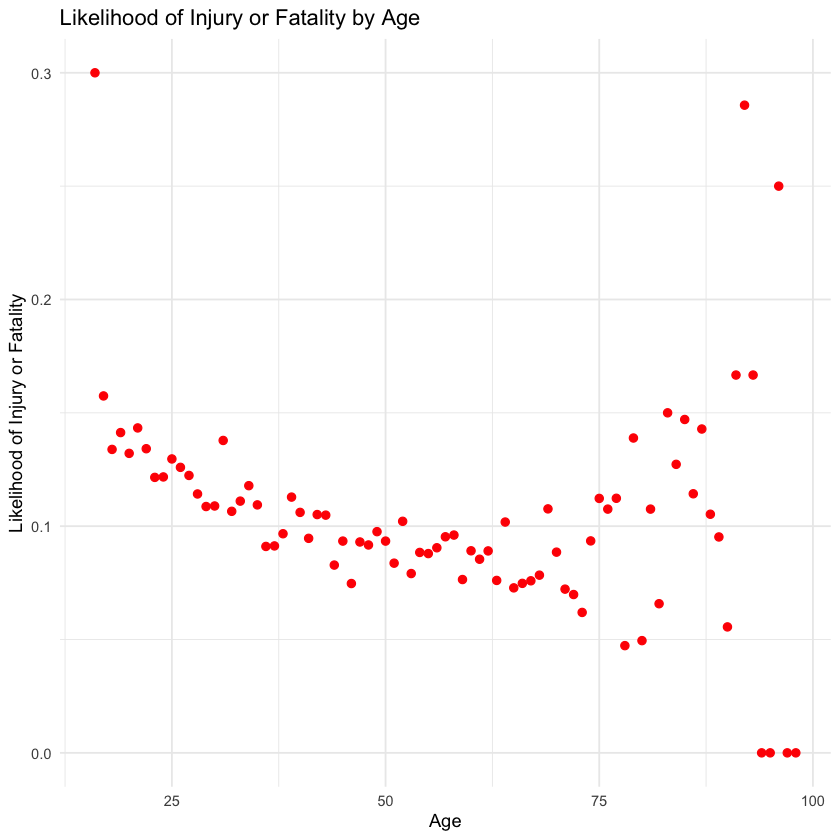

In [21]:
age_summary <- vehicle_data %>%
  group_by(PERSON_AGE) %>%  
  summarise(TOTAL_CASES = n(), INJURY_OR_FATALITY_COUNT = sum(INJURY_OR_FATALITY)) %>%
  mutate(PROBABILITY_PER_AGE = INJURY_OR_FATALITY_COUNT / TOTAL_CASES)  

ggplot(age_summary, aes(x = PERSON_AGE, y = PROBABILITY_PER_AGE)) +
  geom_point(color = "red", size = 2) +  
  labs(title = "Likelihood of Injury or Fatality by Age", x = "Age", y = "Likelihood of Injury or Fatality") + theme_minimal()


There seems to be some outliers at the ends of the age spectrum as seen by the graph, but there is also a clear curve and parabolic relationship that `PERSON_AGE` has with injury and fatalities. We will adjust our model accordingly, adding the poly() function as well as filtering out any non-significant relationships between predictors.

# **Final Model**

In [22]:
vehicle_data <- vehicle_data %>% 
  filter(TYPE_OF_VEHICLE != "Large Vehicles")

mod3 <- glm(INJURY_OR_FATALITY ~ BOROUGH + TYPE_OF_VEHICLE + PERSON_SEX + 
              DRIVER_LICENSE_STATUS + poly(PERSON_AGE,2), 
            data = vehicle_data, family = "binomial")

summary(mod3)

hoslem.test(vehicle_data$INJURY_OR_FATALITY, fitted(mod3))

null_mod2 <- glm(INJURY_OR_FATALITY ~ 1, data = vehicle_data, family = "binomial")

anova(null_mod2, mod3, test = "Chisq")


Call:
glm(formula = INJURY_OR_FATALITY ~ BOROUGH + TYPE_OF_VEHICLE + 
    PERSON_SEX + DRIVER_LICENSE_STATUS + poly(PERSON_AGE, 2), 
    family = "binomial", data = vehicle_data)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.71928    0.11415 -15.061  < 2e-16 ***
BOROUGHBRONX                -0.20698    0.06436  -3.216 0.001300 ** 
BOROUGHBROOKLYN             -0.22150    0.06091  -3.636 0.000276 ***
BOROUGHMANHATTAN            -1.03520    0.06812 -15.197  < 2e-16 ***
BOROUGHQUEENS               -0.22048    0.06118  -3.604 0.000314 ***
TYPE_OF_VEHICLETaxi/Livery   0.28178    0.10967   2.569 0.010186 *  
TYPE_OF_VEHICLEMotorcycle    1.95497    0.11111  17.595  < 2e-16 ***
TYPE_OF_VEHICLEOther        -0.25479    0.12874  -1.979 0.047811 *  
TYPE_OF_VEHICLESUV           0.35160    0.09177   3.831 0.000128 ***
TYPE_OF_VEHICLESedan         0.40571    0.09122   4.447 8.69e-06 ***
PERSON_SEXM                 -0.34443    0.0270


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  vehicle_data$INJURY_OR_FATALITY, fitted(mod3)
X-squared = 12.321, df = 8, p-value = 0.1375


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,67609,46203.60,NA,NA,NA
2,67595,44502.91,14,1700.69,0


Success! We now have a model that aligns with the data and is signficant. 

## **Conclusions From Significant Predictors**:

Conclusions from Borough
* Manhattan has the lowest probability of injury/fatality (Estimate: -1.035, p < 0.001).
* The Bronx, Brooklyn, and Queens also show lower odds, though less significantly than Manhattan.
* Accidents in Manhattan are significantly less likely to result in injuries or fatalities compared to the baseline borough (Staten Island) which might be because of high traffic and less high speed collisions. Further research would be needed to fully explain what is causing this decrease in injuries or fatalities in the boroughs.

Conclusions from Vehicle Type
* Motorcycles have the highest risk (Estimate: 1.95, p < 0.001), meaning motorcycle crashes are much more likely to result in injury or death. Motorcycles don't have the same protections that other motor vehicles do, which could explain why this is the case. 
* Taxis/Livery vehicles also show a higher risk (Estimate: 0.28, p = 0.01).
* SUVs and Sedans have increased risk compared to the baseline vehicle type.
* Other vehicles show a slight negative effect (Estimate: -0.25, p = 0.047), suggesting they are less risky.

Conclusions from Sex of Driver
* Males are significantly less likely to be injured or killed in an accident (Estimate: -0.34, p < 0.001). This might warrant further research as to why this might be the case. 
* Females appear to have a higher risk of injury or fatality in accidents.

Conclusion from Driver’s License Status
* Licensed drivers are significantly less likely to be injured (Estimate: -0.41, p < 0.001).
* Permit drivers shows no strong effect (p = 0.237).

Conclusion from Age
* Age has a significant non linear effect, modeled as a parabolic function in the regression model
* The first order polynomial has a strong negative impact (Estimate: -32.87, p < 0.001).
* The second order term has a positive effect (Estimate: 11.85, p = 0.0003).
* This suggests that injury risk is higher at younger and older ages, following a U-shaped relationship. This makes sense intuitively as younger drivers tend to be risker with their driving and older drivers could be more prone to injury. 

# **Data Visualizations**

Graphing the relationship between borough and injury/fatalities per 100,000 residents shows us the conclusion we got from our regression model. 

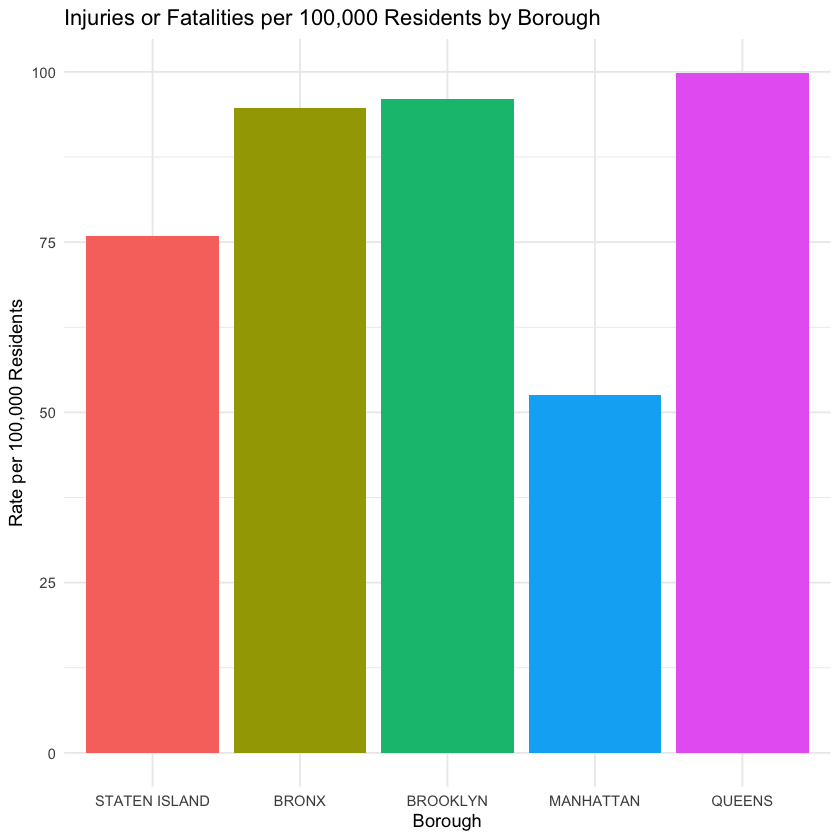

In [23]:

borough_pop <- data.frame(
  BOROUGH = c("BRONX", "BROOKLYN", "MANHATTAN", "QUEENS", "STATEN ISLAND"),
  POPULATION = c(1379946, 2590516, 1596273, 2278029, 491133)
)

borough_pop$BOROUGH <- as.factor(borough_pop$BOROUGH)
vehicle_data <- merge(vehicle_data, borough_pop, by = "BOROUGH")

injury_or_fatality_summary <- vehicle_data %>%
  group_by(BOROUGH) %>% summarize(INJURY_OR_FATALITY_COUNT = sum(INJURY_OR_FATALITY),
                                  POPULATION = first(POPULATION)) %>%
  mutate(RATE_PER_100K = (INJURY_OR_FATALITY_COUNT / POPULATION) * 100000)

ggplot(injury_or_fatality_summary, aes(x = BOROUGH, y = RATE_PER_100K, fill = BOROUGH)) +
  geom_bar(stat = "identity") + labs(title = "Injuries or Fatalities per 100,000 Residents by Borough",
                                     x = "Borough", y = "Rate per 100,000 Residents") + theme_minimal() + theme(legend.position = "none")



Graphing age again shows us clearly how younger and older drivers have higher injury risk. 


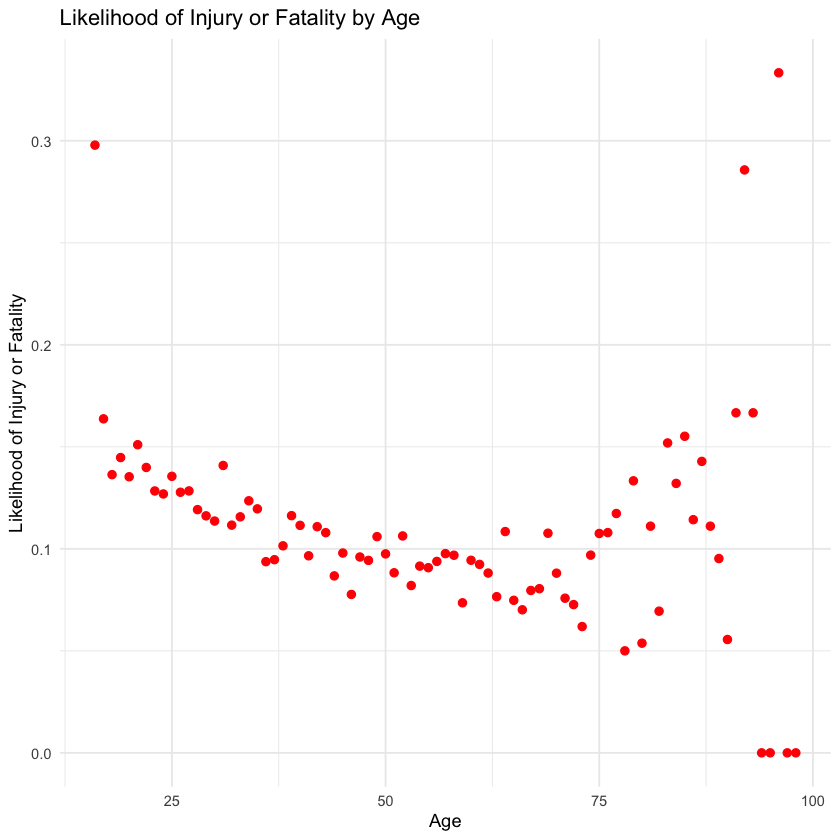

In [24]:
age_summary <- vehicle_data %>%
  group_by(PERSON_AGE) %>%  
  summarise(TOTAL_CASES = n(), INJURY_OR_FATALITY_COUNT = sum(INJURY_OR_FATALITY)) %>%
  mutate(PROBABILITY_PER_AGE = INJURY_OR_FATALITY_COUNT / TOTAL_CASES)  

ggplot(age_summary, aes(x = PERSON_AGE, y = PROBABILITY_PER_AGE)) +
  geom_point(color = "red", size = 2) +  
  labs(title = "Likelihood of Injury or Fatality by Age", x = "Age", y = "Likelihood of Injury or Fatality") + theme_minimal()


The following links to a Tableau Public heatmap, where the number of collisions for intersections are recorded. [Tableau Link](https://public.tableau.com/app/profile/alejandro.ordonez/viz/motor_vehicle_heat_map/Sheet1?publish=yes)

It looks something like this:



# **Final Thoughts**
Overall, this analysis identified key factors influencing injury and fatality risks in NYC. The borough of the accident, type of vehicle involved, driver's sex, and license status all play a significant role in determining the likelihood of an injury.

From the findings, Manhattan stands out as the safest borough in terms of injury rates, likely due to lower speed collisions in traffic. Motorcycles pose by far the highest risk, reinforcing the need for improved safety measures for motorcyclists. Age has a U shaped relationship with injury/fatality, showing increased risk of both younger and older drivers.

While many of these results align with intuition and observations, further research is needed to expand on the underlying reasons of some trends, such as why female drivers have higher injury rates than males or why unlicensed drivers appear less likely to be reported as injured. Future work could incorporate additional factors like time of day, brand of the vehicle, or traffic laws to refine risk assessments even further.